In [1]:
using JSON
using DataFrames
using StatsPlots
using Turing
using LinearAlgebra


### Multi-level model using football match simulation as an example

In [2]:
## First, import the data and do some data wrangling

england_league = JSON.parsefile("./data/matches_England.json")

matches_df = DataFrame(home = [], away = [], score_home = [], score_away = [])

Row,home,away,score_home,score_away
,Any,Any,Any,Any


In [3]:
# example entry for each game in england_league:  "label" => "Burnley - AFC Bournemouth, 1 - 2"
matches = []
for match in england_league
    push!(matches, split(match["label"], ",")) # "Burnley - AFC Bournemouth" # "1 - 2"
end

for match in matches
    home, away = split(match[1], " - ")  # "Burnley" # "AFC Bournemouth" 
    score_home, score_away = split(match[2], " - ") # "1" # "2"
    push!(matches_df,[home, away, parse(Int,score_home), parse(Int,score_away)])
end

matches_df

teams = unique(collect(matches_df[:,1]))

20-element Vector{Any}:
 "Burnley"
 "Crystal Palace"
 "Huddersfield Town"
 "Liverpool"
 "Manchester United"
 "Newcastle United"
 "Southampton"
 "Swansea City"
 "Tottenham Hotspur"
 "West Ham United"
 "Manchester City"
 "Leicester City"
 "Chelsea"
 "Arsenal"
 "Everton"
 "AFC Bournemouth"
 "Watford"
 "West Bromwich Albion"
 "Stoke City"
 "Brighton & Hove Albion"

In [4]:
## Now, our model

@model function football_matches(home_teams, away_teams, score_home, score_away, teams)

    # Hyper priors
    μatt ~ Normal(0, 0.1)
    μdef ~ Normal(0, 0.1)
    σatt ~ Exponential(1)
    σdef ~ Exponential(1)
    home ~ Normal(0, 1)
        
    # Team-specific effects 
    att ~ filldist(Normal(μatt, σatt), length(teams))
    def ~ filldist(Normal(μdef, σdef), length(teams))
    
    offset = mean(att) + mean(def)
    
    # the number of matches
    n_matches = length(home_teams)

    θ_home = Vector{Real}(undef, n_matches)
    θ_away = Vector{Real}(undef, n_matches)
        
    # Modeling score-rate and scores for each match
    for i in 1:n_matches
        # scoring rate
        home_team_idx = findfirst(isequal(home_teams[i]), teams)
        away_team_idx = findfirst(isequal(away_teams[i]), teams)

        θ_home[i] = home + att[home_team_idx] + def[away_team_idx] - offset
        θ_away[i] = att[away_team_idx] + def[home_team_idx] - offset

        # scores
        score_home[i] ~ Poisson(exp(θ_home[i]))  # To ensure positive λ for Poissone distribution
        score_away[i] ~ Poisson(exp(θ_away[i]))
    end
end

football_matches (generic function with 2 methods)

In [5]:
model = football_matches(matches_df[:,1], matches_df[:,2], matches_df[:,3], matches_df[:,4], teams);

posterior = sample(model, NUTS(), 3000)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:10:52


Chains MCMC chain (3000×57×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 685.26 seconds
Compute duration  = 685.26 seconds
parameters        = μatt, μdef, σatt, σdef, home, att[1], att[2], att[3], att[4], att[5], att[6], att[7], att[8], att[9], att[10], att[11], att[12], att[13], att[14], att[15], att[16], att[17], att[18], att[19], att[20], def[1], def[2], def[3], def[4], def[5], def[6], def[7], def[8], def[9], def[10], def[11], def[12], def[13], def[14], def[15], def[16], def[17], def[18], def[19], def[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        μatt    0.0003 

In [6]:
posterior_df=DataFrame(posterior)

DataFrames.transform!(posterior_df, AsTable(Between("att[1]","att[20]")) => ByRow(mean) => :att_mean)
DataFrames.transform!(posterior_df, AsTable(Between("def[1]","def[20]")) => ByRow(mean) => :def_mean)
DataFrames.transform!(posterior_df, AsTable([:att_mean,:def_mean]) => ByRow(sum) => :offset)

Row,iteration,chain,μatt,μdef,σatt,σdef,home,att[1],att[2],att[3],att[4],att[5],att[6],att[7],att[8],att[9],att[10],att[11],att[12],att[13],att[14],att[15],att[16],att[17],att[18],att[19],att[20],def[1],def[2],def[3],def[4],def[5],def[6],def[7],def[8],def[9],def[10],def[11],def[12],def[13],def[14],def[15],def[16],def[17],def[18],def[19],def[20],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size,att_mean,def_mean,offset
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1001,1,-0.118762,-0.0560336,0.33628,0.238707,0.357936,-0.528511,-0.315368,-0.83195,0.0956832,0.146297,-0.535976,-0.359791,-0.483213,0.413308,-0.390422,0.503386,-0.330712,-0.0235137,0.117246,-0.175975,-0.45564,-0.422399,-0.461849,-0.275931,-0.736597,-0.00951888,0.236016,0.202875,-0.0271839,-0.270323,-0.270411,0.0633477,0.070944,-0.39596,0.287956,-0.402421,0.105935,-0.374535,-0.0178288,-0.0593565,0.0443066,0.125687,0.169233,0.26686,0.0217036,-1083.28,7.0,1.0,0.748871,-1083.28,1107.95,0.368115,0.586493,3.0,0.0,0.416676,0.416676,-0.252596,-0.0116337,-0.26423
2,1002,1,-0.0891864,-0.0430258,0.436072,0.284189,0.275402,-0.481962,-0.190767,-0.473028,0.604965,0.136465,-0.249854,-0.527036,-0.891115,-0.0185947,0.0133956,0.654551,0.219956,0.0741546,0.164154,-0.394637,-0.0615844,-0.157438,-0.785733,-0.712606,-0.280022,-0.423857,-0.136546,-0.0173272,-0.364312,-0.530802,0.119461,0.0584014,0.0604448,-0.0973414,0.165619,-0.407701,0.143163,-0.0269089,0.0750216,0.196337,0.235247,0.205504,-0.0773019,0.179438,0.0498172,-1085.51,7.0,1.0,0.63132,-1085.51,1112.14,0.366943,0.951996,3.0,0.0,0.416676,0.416676,-0.167837,-0.0296822,-0.197519
3,1003,1,-0.12026,-0.0175174,0.358757,0.193543,0.391308,-0.20245,-0.0656897,-0.37154,0.267678,0.30225,-0.408534,-0.429379,-0.45986,0.621456,-0.0745965,0.695563,0.0909375,0.248814,0.347642,0.0588193,-0.0943565,-0.00986379,-0.328322,-0.0184514,-0.46364,-0.0692228,0.0902021,0.225226,0.109809,-0.362354,-0.14413,0.136385,0.017911,-0.239234,0.245004,-0.40764,0.13199,-0.263317,0.0513924,0.0647912,0.114325,0.0536562,0.0449185,0.282692,0.0471413,-1075.75,7.0,1.0,0.993053,-1075.75,1104.01,-0.671086,-0.671086,3.0,0.0,0.416676,0.416676,-0.0146761,0.00647729,-0.00819886
4,1004,1,-0.103101,0.0259363,0.376081,0.166146,0.377438,-0.117922,-0.138199,-0.522765,0.221092,0.238648,-0.418235,-0.437333,-0.404594,0.542823,0.0158726,0.712603,0.107362,0.2589,0.384555,0.0699766,0.0384374,-0.0443005,-0.452141,-0.052402,-0.526273,0.0542384,0.0886091,0.164156,-0.00150668,-0.385955,-0.172,0.220912,-0.0555025,-0.265086,0.29277,-0.415587,0.113965,-0.210778,-0.0382487,0.0643542,0.148558,0.170352,0.00180463,0.182258,0.15162,-1077.05,7.0,1.0,0.858294,-1077.05,1097.96,-0.061639,0.408008,3.0,0.0,0.416676,0.416676,-0.0261948,0.00544671,-0.0207481
5,1005,1,0.0321546,-0.0317531,0.395814,0.209453,0.253703,-0.435616,-0.0883931,-0.490783,0.67662,0.207227,-0.285224,-0.411659,-0.647595,0.135375,-0.129098,0.663752,0.0274452,0.08593,0.25068,-0.373267,-0.452397,-0.293238,-0.524602,-0.607101,-0.390541,-0.486485,-0.0085172,-0.127014,-0.399866,-0.33231,0.00737084,-0.196115,-0.0386222,-0.175766,0.0452314,-0.328668,0.0873514,-0.185022,-0.0145124,-0.0401596,0.0672221,0.0586015,-0.0487063,0.112708,-0.145394,-1079.42,7.0,1.0,0.639269,-1079.42,1105.19,0.207829,0.952911,3.0,0.0,0.416676,0.416676,-0.154124,-0.107434,-0.261558
6,1006,1,-0.149554,-0.0495004,0.394003,0.148626,0.366881,-0.506735,-0.172218,-0.541945,0.104314,0.28688,-0.39246,-0.330982,-0.621846,0.

In [7]:
# For this example, we are interested in a pair of teams (no need to use map for all teams)

teamA = "Manchester City"
teamB = "Manchester United"

teamA_id = findfirst(isequal(teamA), teams)
teamB_id = findfirst(isequal(teamB), teams)

teamA_att_post = posterior_df[:,"att[$teamA_id]"]
teamA_def_post = posterior_df[:,"def[$teamA_id]"]

teamB_att_post = posterior_df[:,"att[$teamB_id]"]
teamB_def_post = posterior_df[:,"def[$teamB_id]"]

3000-element Vector{Float64}:
 -0.270322989402386
 -0.530802283333107
 -0.36235392742053785
 -0.3859548017364817
 -0.33231024666521813
 -0.31556904825896404
 -0.3678137457677342
 -0.5925867641516391
 -0.1920063493979056
 -0.5689885110072748
 -0.34852345822956193
 -0.46294026304852653
 -0.49326072092200773
  ⋮
 -0.3765009351316157
 -0.8634389112634879
 -0.7713898959261591
 -0.44948431056872057
 -0.4709893628620419
 -0.44741089795158734
 -0.2561840711596942
 -0.5408610618346681
 -0.4256750271802744
 -0.4403582843741627
 -0.37373492387524354
 -0.33812316918538954

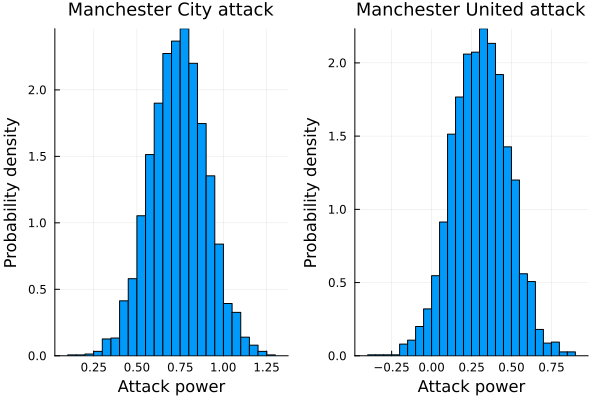

In [9]:
ha1 = histogram(teamA_att_post, title=teamA*" attack", titlefontsize = 12, legend=false, normalized=true);
ha2 = histogram(teamB_att_post, title=teamB*" attack", titlefontsize = 12, legend=false, normalized=true);
plot(ha1, ha2, layout=(1,2));
xlabel!("Attack power");
ylabel!("Probability density")

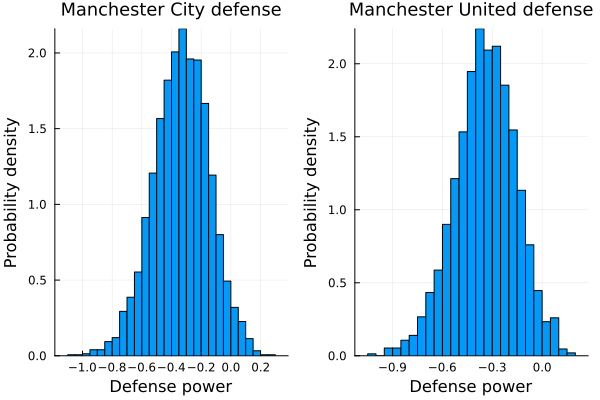

In [10]:
hd1 = histogram(teamA_def_post, title=teamA*" defense", titlefontsize = 12, legend=false, normalized=true);
hd2 = histogram(teamB_def_post, title=teamB*" defense", titlefontsize = 12, legend=false, normalized=true);
plot(hd1, hd2, layout=(1,2));
xlabel!("Defense power");
ylabel!("Probability density")

### Mini Project

Your job is to infer the result of the championship games between two top teams by simulating 500 two-leg finals.

Write a code to perform these simulations.

Use the single-level model and the multi-level model and compare the results.  

For the multi-level model, you may build upon the code above.

Plot the posterior distribution of the cumulative scores as a 2D heat map (teamA total score as the x axis and teamB total score as the y axis).

Calculate the inferred winning probability for each of the two teams.


You should NOT look for and otherwise consult code examples on the internet or other books for this specific problem!!!

Doing so would be considered cheating.  You not only would get zero point for your project, but you also would lose a valuable opportunity for learning how to do Bayesian analysis.

Consulting official online documentaions for Julia and relevant libraries or getting debugging help from StackOverflow is perfectly acceptable.

In [ ]:
# hint: let's simulate 500 hypothetical finals (then you will have a total of 3000*500 samples)

# first leg: teamA is the home team and teamB is the away team

θ_home = posterior_df[:,:home] + posterior_df[:,"att[$teamA_id]"] + posterior_df[:,"def[$teamB_id]"] - posterior_df[:,:offset]
#θ_away = 

teamA_score = rand.(Poisson.(exp.(θ_home)),500)
#teamB_score = 

# second leg: teamA is the away team and teamB is the home team

#θ_home = 
#θ_away = 

#teamA_score += rand.(Poisson.(exp.(θ_away)),500)  # add the first-leg result with the second-leg result
#teamB_score = 